# Analyzing Netflix Dataset (Phase 1)
In this notebook, we will explore the list of shows and their features currently available for streaming on Netflix USA. This data was acquired in July 2022 containing data available in the United States.

**Submitted by: \
Case Study Project Group 15:** \
Deculawan, Ryan Jay \
Pangan, John Paul \
Piano, Gabriel Edward

### Collection Process 
The dataset was a result of Web Scraping techniques deployed using AJAX and GraphQL queries. The data returns and is recorded as a JSON file. 


While production for these titles was present in other countries, the **scope** of the dataset is movies in **English** and are found in the **Netflix movie list in the US**. This limitation may have implications and would limit our analysis to the streaming habits of people in the United States.

### Data Structure

The dataset is divided into two files, both used to provide context and one used to summarize how the movie was perceived by the US audience. 

credits.csv contains 77800 rows of information on Actors and Directors of Netflix titles. While titles.csv has 5850 unique titles: each observation describes a movie and its features. \
A detailed list of variables is included in the next section.

### Dataset Description

### Tabularized List of Variables

| [titles.csv] **Variable Name** | **Description**                                                              |
|--------------------------------|------------------------------------------------------------------------------|
| id:                            | The title ID on JustWatch. This is similar to a unique ID                    |
| title:                         | The name of the show/movie                                                   |
| show_type:                     | If it is a TV show or movie.                                                 |
| release_year:                  | The release year                                                             |
| age_certification:             | The age certification.                                                       |
| runtime:                       | The length per episode if it is a show or the full runtime if it is a movie. |
| genres:                        | Genres that describe the show/movie                                          |
| production_countries:          | A list of countries that produced the show/movie                             |
| seasons:                       | Number of seasons if it's a show                                             |
| imdb_id:                       | The title ID on IMDB.                                                        |
| imdb_score:                    | Score on IMDB.                                                               |
| imdb_votes:                    | Votes on IMDB.                                                               |
| tmdb_popularity:               | Popularity on TMDB.                                                          |
| tmdb_score:                    | Score on TMDB.                                                               |

| **[titles.csv] Variable** | **Description**               |
|---------------------------|-------------------------------|
| person_ID:                | The person ID on JustWatch.   |
| id:                       | The title ID on JustWatch.    |
| name:                     | The actor or director's name. |
| character_name:           | The character name.           |
| role:                     | ACTOR or DIRECTOR.            |

## I. Exploratory Data Analysis

### Analysis Questions

We'll explore how each observation can be best represented by certain features found in the dataset. This will help us later on establish our research question.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys 
import statistics
import random
from scipy.stats import ttest_ind
##sys.path.append("RJ\Desktop\CSMODEL Jupyter\Project")
##os.chdir(r'C:\Users\RJ\Desktop\CSMODEL Jupyter\Project')
%load_ext autoreload
%autoreload 2

from rule_miner import RuleMiner

In [2]:
nx_df = pd.read_csv("titles.csv")

In [3]:
nx_df.columns

Index(['id', 'title', 'type', 'description', 'release_year',
       'age_certification', 'runtime', 'genres', 'production_countries',
       'seasons', 'imdb_id', 'imdb_score', 'imdb_votes', 'tmdb_popularity',
       'tmdb_score'],
      dtype='object')

In [4]:
nx_df['age_certification'].value_counts()

TV-MA    883
R        556
TV-14    474
PG-13    451
PG       233
TV-PG    188
G        124
TV-Y7    120
TV-Y     107
TV-G      79
NC-17     16
Name: age_certification, dtype: int64

nx_df[nx_df['production_countries'] == '[]'].sort_values(by = 'imdb_score', ascending = False)

### 1. On Types of Content

#### a. Identify the Yearly increase of Content per Genre

Comparison / Distribution of Content Type

In [5]:
print(nx_df['type'].unique())
type_frequency = nx_df['type'].value_counts()
type_frequency

['SHOW' 'MOVIE']


MOVIE    3744
SHOW     2106
Name: type, dtype: int64

Text(0.5, 0.98, 'Increase in Movies')

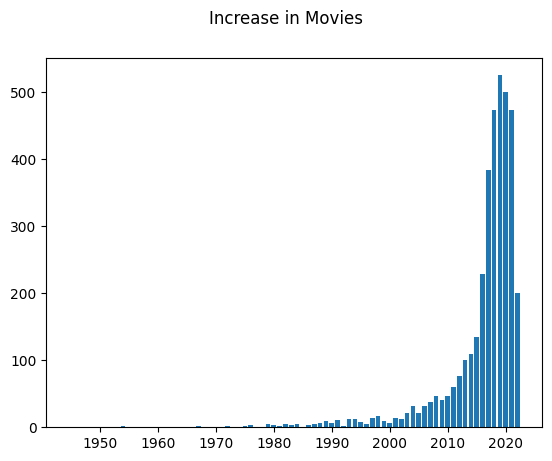

In [6]:
# To check the increase in the number of Movies for each year:
list_year = sorted(nx_df['release_year'].unique())
popular_type = []

#Get the count for each year, append to list
#[[Year, value]]
for year in list_year:
    type_count = nx_df.loc[(nx_df['release_year'] == year)]['type'].value_counts()
    popular_type.append([year,type_count[0]])

popular_type = pd.DataFrame(popular_type, columns=['Year','Count'])

#Display list with a bar graph.
plt.bar(popular_type['Year'],popular_type['Count'])
plt.suptitle('Increase in Movies')

To check for the increase in the number of works **(MOVIES & SERIES)** for each year:

Text(0.5, 0.98, 'Increase in Works')

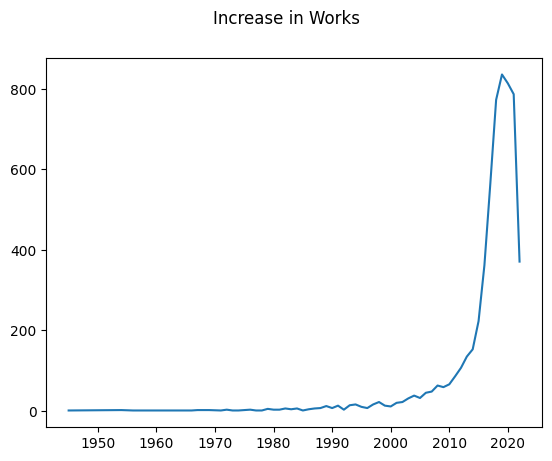

In [7]:
work_count = []

#Get the count for each year, append to list
#[[Year, value]]
for year in list_year:
    count = nx_df.loc[(nx_df['release_year'] == year)]['type'].value_counts().sum()
    work_count.append([year,count])

work_count = pd.DataFrame(work_count, columns=['Year','Count'])

#Display list with a bar graph.
plt.plot(work_count['Year'],work_count['Count'])
plt.suptitle('Increase in Works')

**Notice:** Same shape as the previous one. however, the maximum height has increased from 500 to 800. Notable spike drop during 2020.

### 2. Age Certification

What is the reason for the nan values? 
- Unrated films/series
- Old Unapplicable standards to new movies. 

**Notice:** Upon checking the age certification we see a lot of nan values. 

In [8]:
nx_df[nx_df['age_certification'].isna()].shape

(2619, 15)

#### Data Cleaning


Checking the data, we see that there are \
 a) multiple nan values and \
 b) multiple representations (PG and TV-PG, G and TV-PG)

In [9]:
## Show the NANS for Age Representation

To clean the data, we will set a default value for **nan** and map our multiple representations.

In [10]:
# Create a new dataset based on nx_Df.
test_nx = nx_df.copy()

#Replace nans of age_restriction with Unrated.
test_nx.loc[test_nx['age_certification'].isnull(),'age_certification'] = "Unrated"

#Combine PG % TV-PG and G counterparts.
test_nx['age_certification'] = test_nx['age_certification'].replace({ 'PG':'TV-PG', 'G' : 'TV-G' })

**After cleaning, count the observations for each age classification per year.**

In [11]:
test_dict = {}
test_list = []
certification_types = list(test_nx['age_certification'].unique())

for year in list_year:
    for certification in certification_types: 
        count = test_nx.loc[(test_nx['release_year'] == year) & (test_nx['age_certification'] == certification)].shape[0]
        test_list.append(count)
    test_dict[year] = test_list.copy()
    test_list.clear()

test_df = pd.DataFrame(test_dict).transpose()
test_df.columns = certification_types
test_df

,TV-MA,R,TV-PG,Unrated,TV-14,PG-13,TV-Y,TV-G,TV-Y7,NC-17
1945,1,0,0,0,0,0,0,0,0,0
1954,0,0,0,2,0,0,0,0,0,0
1956,0,0,0,1,0,0,0,0,0,0
1958,0,0,0,1,0,0,0,0,0,0
1959,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2018,130,76,56,349,52,40,20,25,22,3
2019,148,47,48,456,53,42,8,20,13,1
2020,149,62,49,406,56,39,14,28,9,2
2021,150,79,47,360,66,44,12,16,12,1


#### b. Visualize the frequency of content in different age certifications.  
From each age_certification we can generate the graph visualization to show its increase in frequency over time.

**DISCLAIMER:** The start of year was moved from 1945 to 2005 to provide a better visualization in the gradual increase in content.

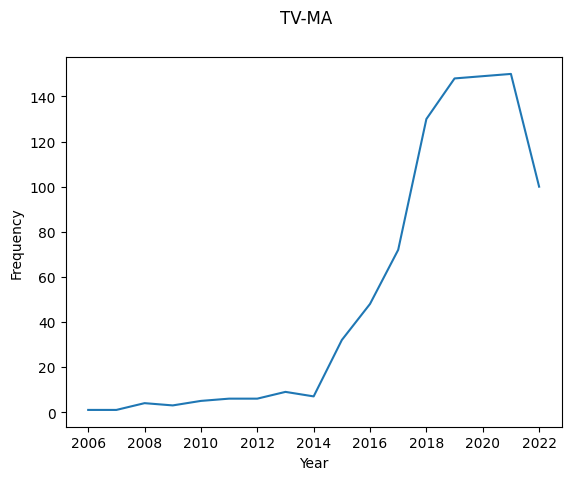

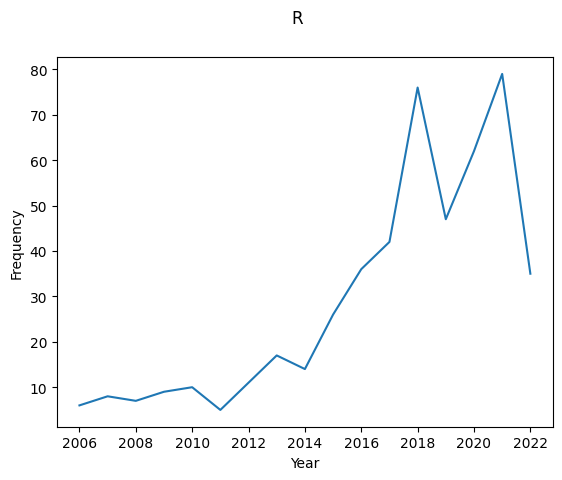

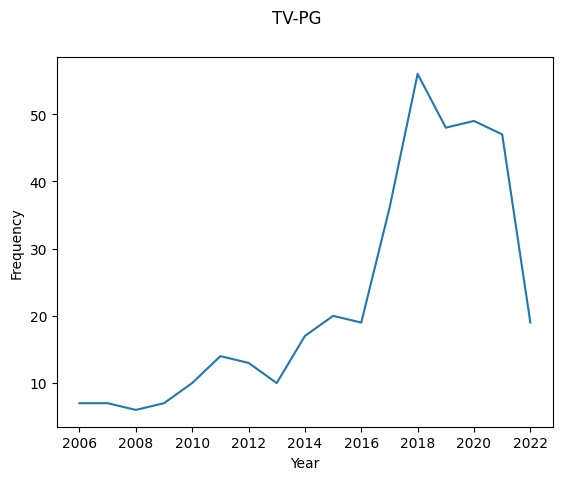

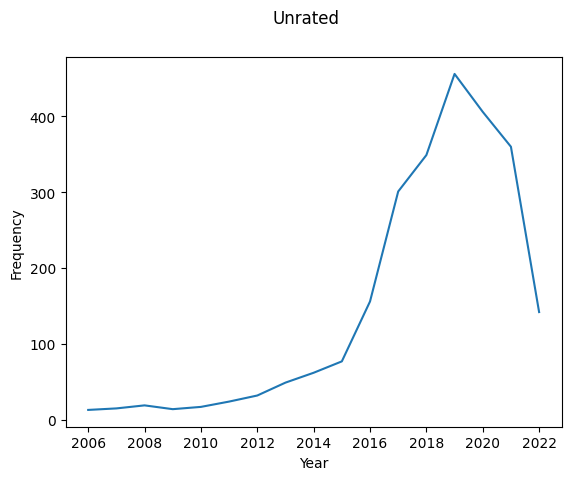

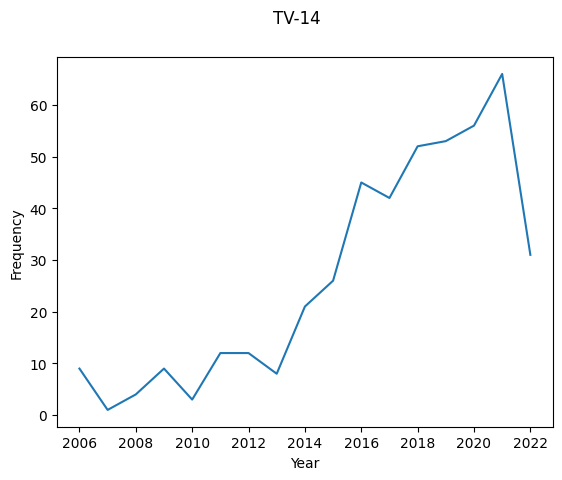

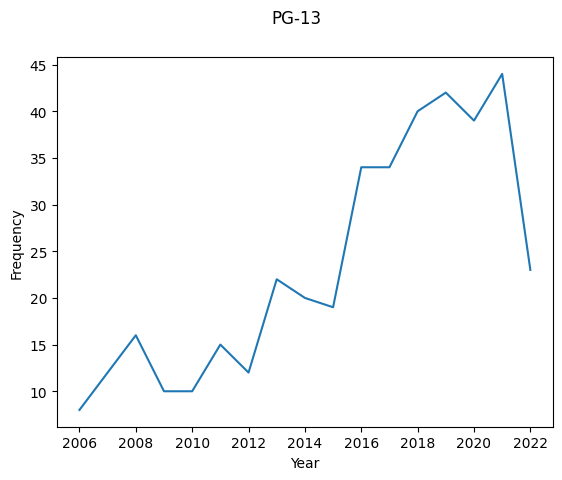

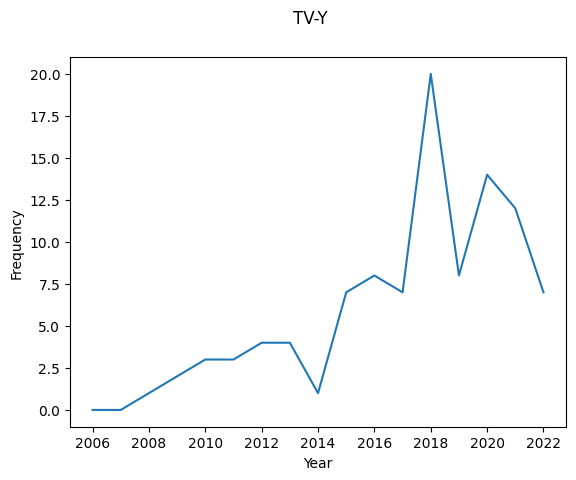

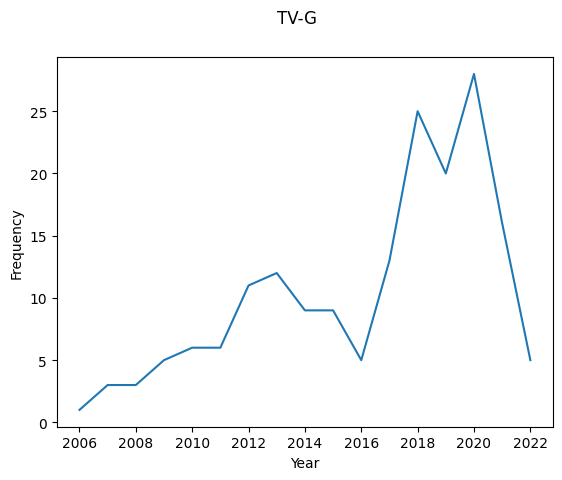

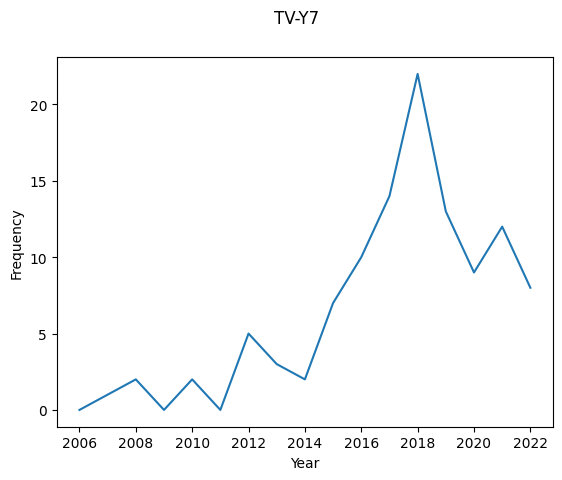

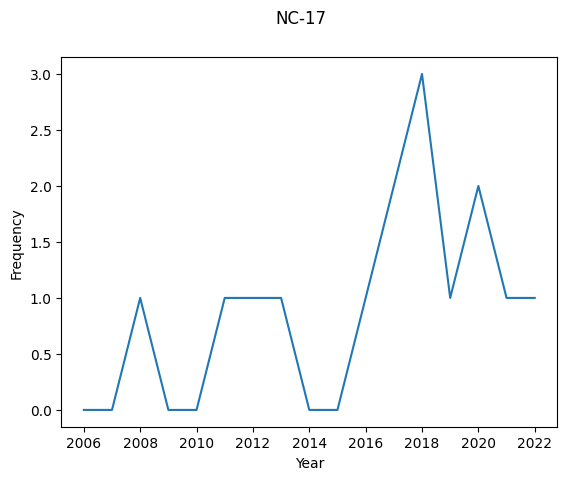

In [12]:
for certification in certification_types: 
    test2_df = test_df[(test_df.index > 2005)][certification]
    plt.figure()
    plt.plot(test2_df)
    plt.xlabel('Year')
    plt.ylabel('Frequency')
    plt.suptitle(certification)
    plt.show()

All certifications aside from NC-17 displays an uptick in the years after 2014. Additionally, a common reocurrence is the sudden decrease in content produced at the start of the pandemic (2020).

### 3. Credits Dataset

The Credits Dataset consist of the Actors and the Director of the shows and movies featured in the titles.csv dataset the id variable can be used to identify the movie or show the person is featured in.

In [13]:
credits_df = pd.read_csv("credits.csv")
credits_df

,person_id,id,name,character,role
0,3748,tm84618,Robert De Niro,Travis Bickle,ACTOR
1,14658,tm84618,Jodie Foster,Iris Steensma,ACTOR
2,7064,tm84618,Albert Brooks,Tom,ACTOR
3,3739,tm84618,Harvey Keitel,Matthew 'Sport' Higgins,ACTOR
4,48933,tm84618,Cybill Shepherd,Betsy,ACTOR
...,...,...,...,...,...
77796,736339,tm1059008,Adelaida Buscato,María Paz,ACTOR
77797,399499,tm1059008,Luz Stella Luengas,Karen Bayona,ACTOR
77798,373198,tm1059008,Inés Prieto,Fanny,ACTOR
77799,378132,tm1059008,Isabel Gaona,Cacica,ACTOR


#### c. Actors on Popular Films

1. List the names of Actors who have appeared atleast twice in the Top 20 most popular movies. 

This part first sort the movies in nx_df based on their popularity. head(20) is used to get the top 20 most popular movies in the dataset.
The ids of these movies was then put into a list named ``top_MovieID``
Using the ``top_MovieID``, we can filter out the credits whose film id is present in the top 20. After the desired set is obtained, the set is further filtered to only get those with the `ACTOR` role. This is done so that we can only see the Actors featured in the top 20 films.
With the `top_artists` already found, we will now find any duplicates, to find if a specific artists is featured in more the one films in the top 20.

In [14]:
top_Movies = nx_df.sort_values(by=['tmdb_popularity'], ascending = False).head(20)
top_MovieID = list(top_Movies['id'])
top_Movies

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
4707,tm1143265,Incantation,MOVIE,Inspired by a true story of a family who belie...,2022,NaN,111,['horror'],['TW'],NaN,tt18968540,6.2,5660.0,2274.044,7.400
1123,ts38796,Stranger Things,SHOW,"When a young boy vanishes, a small town uncove...",2016,TV-14,61,"['scifi', 'thriller', 'drama', 'fantasy', 'hor...",['US'],5.0,tt4574334,8.7,1101055.0,2226.231,8.635
4702,tm1067148,The Sea Beast,MOVIE,When a young girl stows away on the ship of a ...,2022,PG,115,"['comedy', 'family', 'fantasy', 'scifi', 'anim...",['US'],NaN,tt9288046,7.1,18852.0,1723.363,7.634
4714,tm928497,Valley of the Dead,MOVIE,They're soldiers on different sides of the war...,2022,R,101,"['comedy', 'horror', 'war', 'fantasy', 'thrill...",['ES'],NaN,tt10127708,6.5,114.0,1668.296,6.303
4696,tm852360,The Man from Toronto,MOVIE,"In a case of mistaken identity, the world’s de...",2022,PG-13,110,"['action', 'thriller', 'drama', 'romance', 'co...",['US'],NaN,tt11671006,5.8,31497.0,1439.906,6.449
4693,ts252861,Resident Evil,SHOW,Nearly three decades after the discovery of th...,2022,TV-MA,51,"['scifi', 'thriller', 'action', 'horror']",['US'],1.0,tt9660182,3.7,24982.0,1387.392,5.956
5059,tm1210379,Collision,MOVIE,"Over the course of one fateful day, a corrupt ...",2022,NaN,99,"['drama', 'crime', 'thriller']",['ZA'],NaN,tt10809742,3.9,886.0,1194.149,5.946
833,ts20110,Peaky Blinders,SHOW,"A gangster family epic set in 1919 Birmingham,...",2013,TV-MA,58,"['crime', 'drama', 'european']",['GB'],6.0,tt2442560,8.8,511668.0,1038.077,8.558
4699,tm1020438,Spiderhead,MOVIE,"In the near future, convicts are offered the c...",2022,R,106,"['scifi', 'thriller', 'drama', 'action', 'crime']",['US'],NaN,tt9783600,5.4,43239.0,996.869,5.800
1136,ts36147,Lucifer,SHOW,"Bored and unhappy as the Lord of Hell, Lucifer...",2016,TV-14,47,"['scifi', 'crime', 'drama', 'fantasy']",['US'],6.0,tt4052886,8.1,313124.0,922.112,8.523


In [15]:
credit_index = np.where(credits_df['id'].isin(top_MovieID))[0]
credits = credits_df.filter(items = credit_index , axis = 0)
top_artists = credits[credits['role'] == 'ACTOR']
top_artists

,person_id,id,name,character,role
4467,7302,ts9,Norman Reedus,Daryl Dixon,ACTOR
4468,11306,ts9,Melissa McBride,Carol Peletier,ACTOR
4469,22811,ts9,Lauren Cohan,Maggie Greene,ACTOR
4470,9766,ts9,Christian Serratos,Rosita Espinosa,ACTOR
4471,84007,ts9,Josh McDermitt,Eugene Porter,ACTOR
...,...,...,...,...,...
71403,231777,ts307745,Hovik Keuchkerian,NaN,ACTOR
71404,1164068,ts307745,Ahikar Azcona,NaN,ACTOR
71405,183630,ts307745,Miguel Herrán,NaN,ACTOR
71406,118533,ts307745,Alba Flores,Nairobi,ACTOR


In [16]:
duplicated_artist = top_artists.duplicated(subset = ['person_id'])
top_artists.loc[duplicated_artist]

,person_id,id,name,character,role
64393,7991,tm1067148,Brian T. Delaney,Jim Nicklebones (voice),ACTOR
64541,2681,tm928497,María Botto,Sor Flor,ACTOR


In [17]:
(credits[credits['person_id'] == 7991])

,person_id,id,name,character,role
64203,7991,tm305129,Brian T. Delaney,Additional Voice (voice),ACTOR
64393,7991,tm1067148,Brian T. Delaney,Jim Nicklebones (voice),ACTOR


In [18]:
(credits[credits['person_id'] == 2681])

,person_id,id,name,character,role
64287,2681,tm1126268,María Botto,Paola,ACTOR
64541,2681,tm928497,María Botto,Sor Flor,ACTOR


`In the top 20 shows and Movies, Only 2 Artists in multiple shows, more specifically they were featured in only 2 different shows. The Artists are Brian T. Delaney and Maria Botto, However only 2 artists shows that a certain actor may not be the only reason for a Movie or Show's popularity`

2. Is there a specific director that produces top scoring films

To find the top scoring films, the nx_df is sorted by their ``imdb_score`` value. The top 20 highest scoring film's ``id`` are then placed on a list called `top_MovieID`. 

Credits_df is then filtered so that the only ones left will be those whose ``id`` is present in `top_MovieID`. The set is then further filtered to only have those that have the role ``DIRECTOR``

After Obtaining the list of `top_Director`, We will then find if there are any duplicate directors in the Top 20. This is done to see if there are Directors that consistently produce high scoring films.

In [19]:
top_Movies = nx_df.sort_values(by=['imdb_score'], ascending = False).head(20)
top_MovieID = list(top_Movies['id'])
top_credits = credits_df['id'].isin(top_MovieID)
credit_index = top_credits[top_credits].index
credits = credits_df.filter(items = credit_index , axis = 0)
top_Director = credits[credits['role'] == 'DIRECTOR']
top_Director

,person_id,id,name,character,role
3884,451452,ts28516,Bruno Stagnaro,NaN,DIRECTOR
12953,859215,ts32835,Hiroshi Koujina,NaN,DIRECTOR
22541,728308,ts37660,Shin Won-ho,NaN,DIRECTOR
44212,195528,ts81120,Jason Hehir,NaN,DIRECTOR
65409,937765,tm996762,Sashi Kiran Tikka,NaN,DIRECTOR


In [20]:
duplicated_directors = top_Director.duplicated(subset = ['person_id']).sum()
duplicated_directors

0

`In the top 20 shows, No Show or Movie shares the Same Director, this shows that no specific director has multiple entries in the top 20 Movies and Shows. However not all shows had a Director stored in the credits dataframe`

### 4. Season and IMDB Score Correlation

#### d. Identify if a correlation exists between the number of seasons in a show and its corresponding IMDB rating.

In [21]:
season_rating = nx_df.groupby("seasons").agg({"imdb_score": ["mean"]})
season_rating.sort_values(("imdb_score", "mean"), ascending=False)

,imdb_score
,mean
seasons,
21.0,8.800000
32.0,8.700000
9.0,8.222222
20.0,7.800000
37.0,7.800000
11.0,7.650000
15.0,7.633333
19.0,7.600000


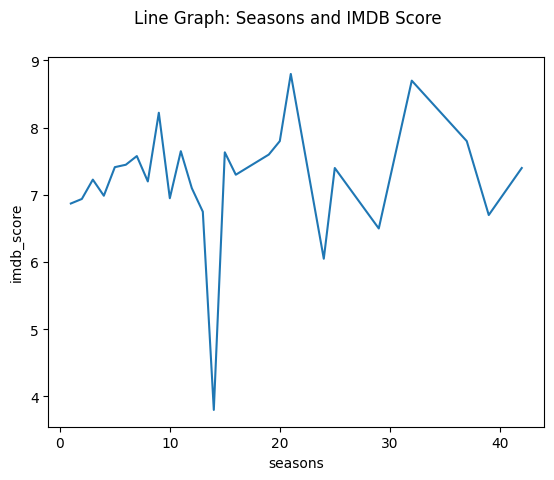

In [22]:

plt.plot(season_rating)
plt.xlabel('seasons')
plt.ylabel('imdb_score')
plt.suptitle('Line Graph: Seasons and IMDB Score')
plt.show()

In [23]:
seasons_score = nx_df[['seasons', 'imdb_score']]
seasons_score.corr(method="spearman")

,seasons,imdb_score
seasons,1.000000,0.155145
imdb_score,0.155145,1.000000


C:\Users\RJ\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


Text(0.5, 1.0, 'Relationship of Number of Seasons and IMDB Score')

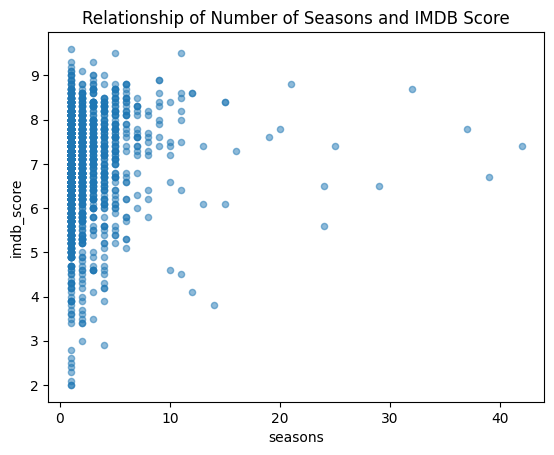

In [24]:
seasons_score.plot.scatter(x='seasons', y='imdb_score', alpha=0.5)
plt.title('Relationship of Number of Seasons and IMDB Score')

### 5. Most Popular Genre Combinations
Ranking Genre Combinations by their TMDB Popularity

In [25]:
genre_pop = nx_df.groupby("genres").agg({"tmdb_popularity": ["mean"]})
genre_pop_10 = genre_pop.sort_values(("tmdb_popularity", "mean"), ascending=False).head(10)
genre_pop_10

,tmdb_popularity
,mean
genres,
"['scifi', 'thriller', 'drama', 'fantasy', 'horror']",2226.2310
"['comedy', 'family', 'fantasy', 'scifi', 'animation']",1723.3630
"['comedy', 'horror', 'war', 'fantasy', 'thriller', 'action']",1668.2960
"['action', 'thriller', 'drama', 'romance', 'comedy']",1439.9060
"['scifi', 'thriller', 'drama', 'action', 'crime']",996.8690
"['scifi', 'crime', 'drama', 'fantasy']",922.1120
"['drama', 'sport', 'comedy']",746.9280
"['scifi', 'thriller', 'action', 'horror']",698.9635


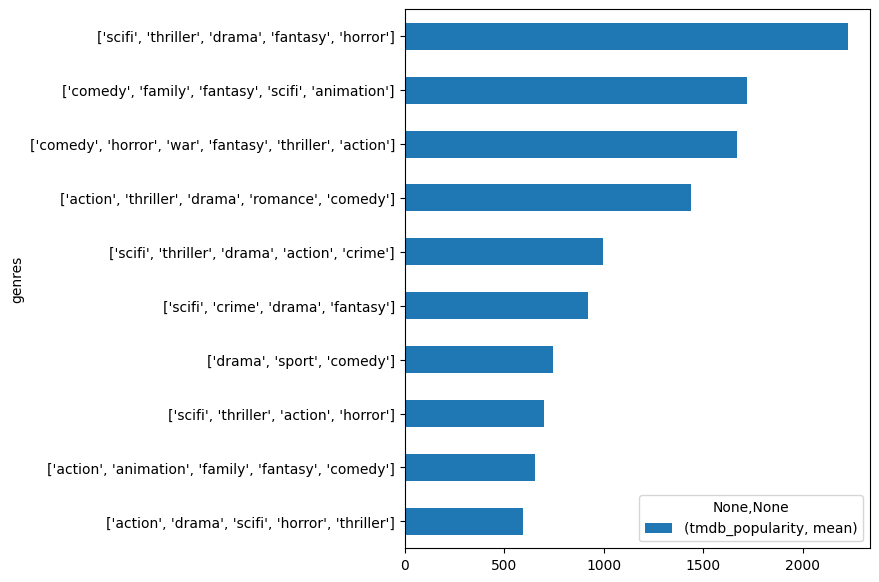

In [26]:
genre_pop_10.plot.barh(figsize=(6,7)).invert_yaxis()

After grouping based on genre, we aggregated the TMDB popularity for these content groups. The test showed that the genre combination of 'scifi', 'thriller', 'drama', 'fantasy', 'horror' are the most popular genre combination amongst the groups.

### TMDB vs IMDB?

- The difference is in the number of entries. According to Francois Carpentier, TMDB offers better freedom and stronger privacy compared to IMDB. The drawback with TMDB is it only has listed 4.4 million titles compared to IMDB's 11 million. 

## II. Research Question

### What are the Genres that usually go together?

After checking the number of content, season and popularity correlations the researchers observed how each movie record could be represented by its genres. 

Knowledge on what combination of genres usually go together can give us insight on the type of content the US audience consumes regularly.

## III. [Phase 2]: Capturing Genres

**Handling NaN values**

In [27]:
nx_df[nx_df['genres'] == '[]'].shape

(59, 15)

With the relatively low number of missing values, we can `opt to remove`.

### Data Cleaning

In [28]:
#drop the content  where [] is the genre.
genre_df = nx_df.copy()
genre_df = genre_df.drop(genre_df[nx_df['genres'] == '[]'].index)

#Find the types of genres.
#for each observation, get the individual genres and place them in a list.
#perform one hot encoding.

In [29]:
words = []
cleaned_genre = []
list_of_genres = []
for i in genre_df['genres'].index:
    for j in  genre_df['genres'][i].split("'"):
        if(len(j) > 2):
            words.append(j)
            if(list_of_genres.count(j) == 0):
                list_of_genres.append(j)
    cleaned_genre.append(words.copy())
    words.clear()
genre_df['genres'] = cleaned_genre
len(genre_df)

5791

Because an observation can have multiple genres, we need to **separate them first**.

In [30]:
#Get all the genre options
final_genre_df = pd.DataFrame([[0 for _ in range(len(list_of_genres))] for _ in range(5791)], columns=list_of_genres)
genre_df['index'] = list(range(0,5791))
genre_df = genre_df.set_index('index')

### Data Modelling: [Ordinal] One Hot Encoding

For all observations, we perform **Ordinal encoding** on each genre. 

**Assumption:** Because content genre can be a combination of genres, the **order of appearance** is used to **rank** and determine the primary genre 

In [31]:
for row in genre_df.index:
    ctr = len(genre_df['genres'][row])
    for genre in range(ctr):  #How many Genres a content has.
        for types in range(len(list_of_genres)):
            if(genre_df['genres'][row][genre] == list_of_genres[types]):
                try:
                    final_genre_df.iloc[row,types] = ctr
                    ctr -= 1
                except:
                    print(row, types)

In [32]:
final_genre_df

,documentation,drama,crime,action,thriller,european,fantasy,comedy,war,romance,western,history,music,family,horror,scifi,animation,reality,sport
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,4,0,3,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,2,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5786,0,1,0,0,0,0,0,2,0,3,0,0,0,0,0,0,0,0,0
5787,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
5788,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5789,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


### e. Retriveing Association Rules

Instantiate a `RuleMiner` object with support threshold (`support_t`) equal to `85` and confidence threshold (`confidence_t`) equal to `0.75`. 

Assign the object to variable `gm_01`.

In [33]:
gm_01 = RuleMiner(85,0.75)

In [34]:
gm_01.get_association_rules(final_genre_df)

[[['action', 'family', 'fantasy'], ['comedy']],
 [['action', 'family', 'fantasy'], ['animation']],
 [['animation', 'fantasy', 'scifi'], ['action']],
 [['action', 'animation', 'family'], ['comedy']],
 [['action', 'comedy', 'family'], ['animation']],
 [['action', 'comedy', 'scifi'], ['animation']],
 [['animation', 'comedy', 'fantasy'], ['family']],
 [['animation', 'family', 'fantasy'], ['comedy']],
 [['comedy', 'family', 'fantasy'], ['animation']],
 [['animation', 'family', 'scifi'], ['comedy']],
 [['comedy', 'family', 'scifi'], ['animation']]]

## IV. Statistical Inference

### f. Retrieving Frequent Itemsets

In [35]:
final_dup = final_genre_df.copy()
passed_genre = gm_01.get_frequent_itemsets(final_dup)

In [36]:
passed_genre

[['action', 'crime', 'drama', 'thriller'],
 ['action', 'drama', 'scifi', 'thriller'],
 ['action', 'drama', 'fantasy', 'scifi'],
 ['action', 'comedy', 'family', 'fantasy'],
 ['action', 'animation', 'comedy', 'fantasy'],
 ['action', 'animation', 'family', 'fantasy'],
 ['action', 'animation', 'fantasy', 'scifi'],
 ['action', 'animation', 'comedy', 'family'],
 ['action', 'animation', 'comedy', 'scifi'],
 ['animation', 'comedy', 'family', 'fantasy'],
 ['animation', 'comedy', 'fantasy', 'scifi'],
 ['animation', 'comedy', 'family', 'scifi']]

In [37]:
popularity_of_frequent = []
popularity_of_not_frequent = []

In [38]:
#For each observation in genres
#For each frequent itemset
#check if the genre of the observation falls under any of the frequent itemset
#If it is append its popularity rating to a list and go to next observation.

In [39]:
for i in range(len(genre_df.genres)):
    flag = 0
    for j in passed_genre:
        if(set(j).issubset(genre_df.genres[i])):
            popularity_of_frequent.append(genre_df.tmdb_popularity[i])
            flag = 1
            break  # No need to check other sets
    if flag == 0 and genre_df.tmdb_popularity[i] > 0 :
            popularity_of_not_frequent.append(genre_df.tmdb_popularity[i])

len(popularity_of_not_frequent)

5137

Using our itemset sample, the **difference** in the means of movies part of a frequent itemset and movies not part of a frequent dataset is

In [40]:
pd.Series(popularity_of_frequent).mean() - pd.Series(popularity_of_not_frequent).mean()

25.436890131833906

### Hypothesis Testing: T-Test

Before performing any test, we need to take equal samples from both of our list.

In [41]:
random.seed(14)
popularity_of_frequent_sample = random.sample(popularity_of_frequent, 100)
popularity_of_not_frequent_sample = random.sample(popularity_of_not_frequent, 100) 

We set up our hypothesis as follows \
$H_0$ (null hypothesis): 	**μ = 0.**

$H_A$ (alternative hypothesis): 	**μ ≠ 0.**


$H_0$: There is **no difference** between the popularity score of content with genres that are part of a frequent itemset and  content with genres that are not part of a frequent itemset.

$H_A$ : There is a **difference** between the popularity score of content with genres that are part of a frequent itemset and  content with genres that are not part of a frequent itemset.

We can use a t-test to compare the means from the unpaired groups. We set the `equal_var` parameter to `False` because we don't want to assume that the population has equal variances.

In [42]:
ttest_ind(popularity_of_frequent_sample, popularity_of_not_frequent_sample, equal_var = False)

Ttest_indResult(statistic=4.315393762762202, pvalue=3.236111984163656e-05)

## V. Conclusion

After performing a t-test the following conclusions can be made:
- Using a significance level of 0.05, the p-value 3.236e-05 is **statistically significant**.
- Because the p-value is less than the significance level (0.05), **reject the null hypothesis**.
- Thus, the data provides strong evidence that **there is a difference** etween the popularity score of content with genres that are part of a frequent itemset and content with genres that are not part of a frequent itemset at a **significance level of 5%**.

## VI. Insights

We chose to work on this dataset because of our love for movies. To understand how to generate insights from the data, we looked for a feature that could accurately represent each movie observation. We decided to focus on genres because we were curious to find out which set tend to go together.

Using **ordinal encoding** as our data modeling technique, we were able to take advantage of the inherent order in our dataset. After taking our frequent itemsets, we decided to check whether the content under these genres are popular or not. Under a **significance level of 5%**, our results indicate that there is a **difference in the popularity** of content produced under certain sets of genres compared to the popularity of content produced under other sets of genres.

This `insight supports our initial question about the relationship between genre combinations.` Its relationship with popularity suggests that there may be a **correlation that warrants further exploration.**